In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from environment.single_family_home import SingleFamilyHome

In [4]:
env = SingleFamilyHome("./environment/configs/config_hourly.json")
env.reset()

({'carbon_intensity': array([40.17], dtype=float32),
  'timestep': array([0.], dtype=float32),
  'co2_emitted': array([0.], dtype=float32),
  'energy_storage_system_charge': array([0.], dtype=float32),
  'flexible_demand_schedule': array([6.6780605], dtype=float32),
  'tcl_indoor_temperature': array([20.], dtype=float32)},
 {})

# Static Components Figure

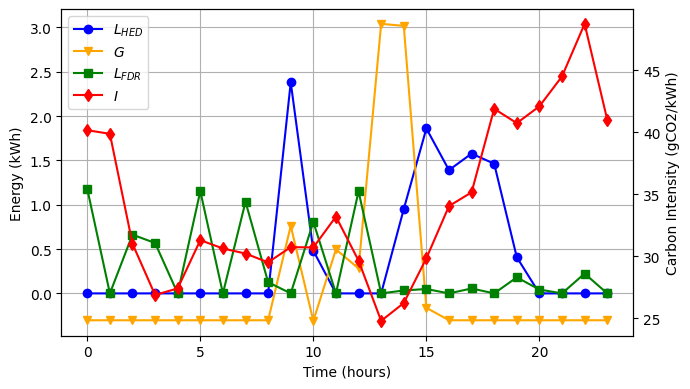

In [8]:

fig, ax = plt.subplots(figsize=(7, 4))
line1, = ax.plot(env.hed.episode.values[:24], label=r"$L_{HED}$", marker='o', color='blue')
line2, = ax.plot(env.rsa.episode.values[:24], label=r"$G$", marker='v', color='orange')
line3, = ax.plot(env.fdr.episode.values[:24], label=r"$L_{FDR}$", marker='s', color='green')
ax2 = ax.twinx()
line4, = ax2.plot(env.ees.episode.values[:24], label="$I$", marker='d', color='red')

# Create a list of lines and labels
lines = [line1, line2, line3, line4]
labels = [l.get_label() for l in lines]

# Create the legend box
ax.legend(lines, labels, loc='upper left')

# Set labels for the x and y axes
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Energy (kWh)')
ax2.set_ylabel('Carbon Intensity (gCO2/kWh)')


# Add a grid to the plot
ax.grid(True)

# Adjust subplot parameters
plt.tight_layout()

# Show the plot
plt.show()

# IDle reward

In [8]:
import numpy as np
from analysis import load_data
data_dict = load_data("./logs/hourly")["idle"]

data_dict["cache"].keys()

dict_keys(['given_reward', 'battery_reward', 'fdr_reward', 'tcl_reward', 'discomfort'])

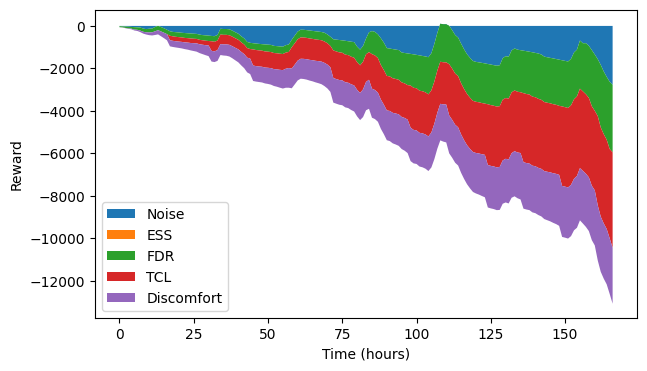

In [24]:
keys = list(data_dict["cache"].keys())
lists = [np.cumsum(data_dict["cache"][key]) for key in keys]

fig, ax = plt.subplots(figsize=(7, 4))
ax.stackplot(range(len(lists[0])), lists, labels=['Noise', 'ESS', 'FDR', 'TCL', 'Discomfort'])

ax.legend(loc='lower left')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Reward')

plt.show()